# AB 테스트 결과분석 모듈 활용 예시

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pymysql
from datetime import timedelta

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format

import random
from my_modules.ExpTool import exp_result

# 0 데이터 불러오기
- bigquery sample data 활용
- 전환 데이터를 a,b로 랜덤 분기하여 활용

### 데이터 전처리 조건
- sample_id: 샘플의 고유 아이디
- converted: 전환여부 (0,1)
- group: ab테스트 분기처리한 결과

In [4]:
import pydata_google_auth

SCOPES = [
  'https://www.googleapis.com/auth/cloud-platform',
  'https://www.googleapis.com/auth/drive',
  'https://www.googleapis.com/auth/bigquery'
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES, auth_local_webserver=True)

query = '''
select visitId as sample_id,
    max(case h.eCommerceAction.action_type when '6' then 1 else 0 end) as converted
from `bigquery-public-data.google_analytics_sample.ga_sessions_*` 
    LEFT JOIN UNNEST(hits) as h
where parse_date('%Y%m%d', _TABLE_SUFFIX) BETWEEN DATE('2016-08-01') AND DATE('2017-07-31') 
    and h.eCommerceAction.action_type in ('2','6')
group by visitId
having max(case h.eCommerceAction.action_type when '2' then 1 else 0 end) > 0 
'''

df = pd.read_gbq(query=query, project_id="public-data-projects", credentials=credentials, dialect='standard')

# a, b그룹 랜덤 분기
df['group'] = df.apply(lambda x: 'a' if random.randint(0,1) else 'b', axis = 1)

print(df.shape)
df.head()

(123264, 3)


,sample_id,converted,group
0,1493954216,0,a
1,1493902915,0,b
2,1493951332,0,b
3,1493921149,0,a
4,1493890425,0,b


# 1 실험 평가

In [5]:
result = exp_result(df, cl = 0.99, su = 500)

100%|██████████| 246/246 [00:02<00:00, 107.24it/s]


    [CL: 0.99]
    +-------------------+
    |   |a      |b      |
    +-------------------+
    |n  |61628  |61372  |
    |p  |0.0767 |0.0753 |
    +-------------------+
    - Uplift: -0.0013
    - Confidence Interval: -0.0033 to 0.0006
    - P value: 0.22
    - Statistical significance: False
    


- a,b의 차이는 -0.0013입니다.
- p_value가 0.01보다 크니 귀무가설을 채택합니다.
- exp_result함수는 샘플수에 따른 결과 테이블을 반환합니다.
- n에따라 B-A 의 신뢰구간이 어떻게 바뀌였는지 볼 수 있습니다.

In [10]:
result.head()

,uplift,ci_low,ci_high,p_value,stat_sig
500,0.02,-0.01,0.05,0.14,False
1000,0.00,-0.02,0.02,0.87,False
1500,-0.00,-0.02,0.01,0.79,False
2000,-0.01,-0.02,0.01,0.38,False
2500,-0.01,-0.02,0.01,0.34,False


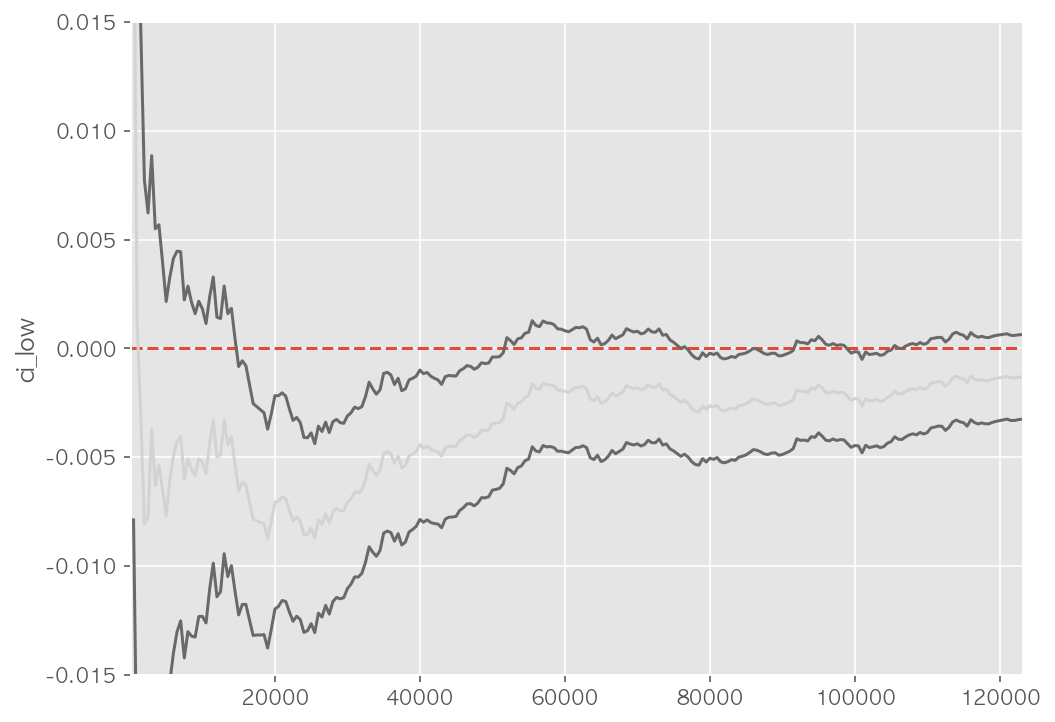

In [7]:
plt.figure(figsize = (8,6))
plt.xlim(100,df.shape[0])
plt.ylim(-0.015,0.015)
plt.axhline(0, ls = '--')

sns.lineplot(x = result.index, y = 'ci_low', data = result, color = 'dimgray')
sns.lineplot(x = result.index, y = 'ci_high', data = result, color = 'dimgray')
sns.lineplot(x = result.index, y = 'uplift', data = result, color = 'lightgray')

plt.show()

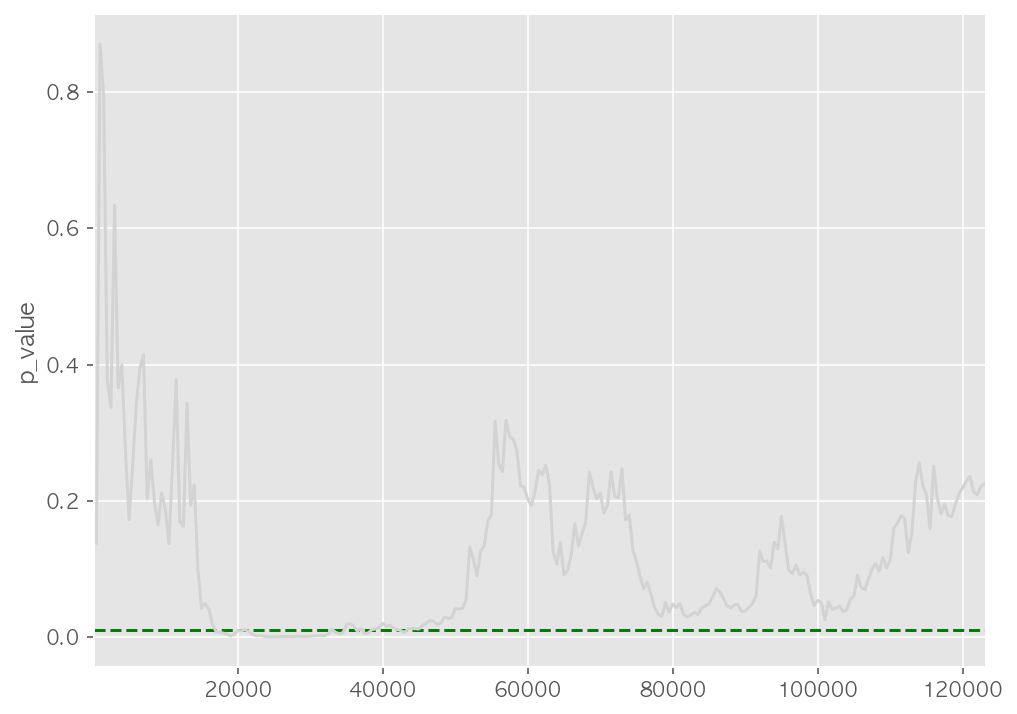

In [9]:
plt.figure(figsize = (8,6))
plt.xlim(100,df.shape[0])
plt.axhline(0.01, ls = '--', color = 'g')

sns.lineplot(x = result.index, y = 'p_value', data = result, color = 'lightgray')

plt.show()